In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Helper functions

These are borrowed from the `Convert.ipynb` file.

In [10]:
headings = ['Building Identifier',
            'Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Contributor']

In [11]:
df = pd.read_excel('Dataset/dataset.xlsx',header=1,usecols='B:BKX')

In [12]:
mapper = pd.read_excel('/Users/alex/Downloads/Mapping material names_20210324.xlsx',header=2,usecols='B:U').replace(r'\n','', regex=True) 

In [13]:
additional_categories_map = {v:k for k,v in {
    'Continuous Footings':'0CF',
    'Foundation Walls':'0FW',
    'Spread Footings':'0SF',
    'Column Piers':'0CP',
    'Columns Supporting Floors':'CSF',
    'Floor Girders and Beams':'FGB',
    'Floor Trusses':'0FT',
    'Floor Joists':'0FJ',
    'Columns Supporting Roofs':'CSR',
    'Roof Girders and Beams':'RGB',
    'Roof Trusses':'0RT',
    'Roof Joists':'0RJ',
    'Parking Bumpers':'0PB',
    'Precast Concrete Stair Treads':'PCS',
    'Roof Curbs':'0RC',
    'Exterior Wall Construction':'EWC',
    'Composite Decking':'CPD',
    'Cast-in-Place concrete':'CIC',
    'Floor Structural Frame':'FSF',
    'Associated Metal Fabrications':'AMF',
    'Floor Construction Supplementary Components':'FCS',
    'Roof Construction Supplementary Components':'RCS',
    'Residential Elevators':'0RE',
    'Vegetated Low-Slope Roofing':'VLR',
    'Swimming Pools':'SWP',
    'Excavation Soil Anchors':'ESA',
    'Floor Trusses':'FTS',
    'Roof Window and Skylight Performance':'RWS'}.items()
}

additional_categories_map['0FT'] = 'Floor Trusses'

headings = ['Building Identifier',
            'Country',
 'City',
 'Quality / Stage of Data',
 'Construction Date',
 'Building Type',
 'Contributor']

In [14]:
def get_material_name(l):
    split = re.split('[_\.\ ]',l) #Split up the code into its requisite parts
    result = mapper[mapper['Unnamed: 7'] == split[1]+'.'+split[2]] #Filter by Level 4 Master Format
    if len(result) == 0:
        result = mapper #If that code does not exist in the table, reset
    if len(result) == 1:
        return result['Mapping Table'].values[0] #If it maps to exactly one value, return that. We do this check after every step
    if split[3] != '000': #Check if there is an additional code, and if so filter by that
        result = result[result['Level 5\n'] == additional_categories_map[split[3]]]
        if len(result) == 1:
            return result['Mapping Table'].values[0]
        
    #Now filter by UniFormat.
    #Filter only by the level of UniFormat present. If the code is XX 00 00, for example, then we only have Level 1.
    if int(split[5]) == 0: 
        result = result[result['Unnamed: 12'] == f'{split[4]} 00 00']
        if len(result) == 1:
            return result['Mapping Table'].values[0]
    elif int(split[6]) == 0:
        result = result[(result['Unnamed: 14'] == f'{split[4]} {split[5]} 00') | (result['Unnamed: 16'] == f'{split[4]} {split[5]} 00')]
        if len(result) == 1:
            return result['Mapping Table'].values[0]
    else:
        result = result[result['Unnamed: 18'] == f'{split[4]} {split[5]} {split[6]}']
        if len(result) == 1:
            return result['Mapping Table'].values[0]
        
    #If we couldn't find it, or there is an unspecified edge case, return None. 
    if len(result) == 0:
        return None
    
    #If there are multiple results but they all map to the same material, return that material.
    if all(element == result['Mapping Table'].values[0] for element in result['Mapping Table'].values):
        return result['Mapping Table'].values[0]
    else:
        return None

# 1. Plot sample figures

Here we plot building material mass, and volume histograms.

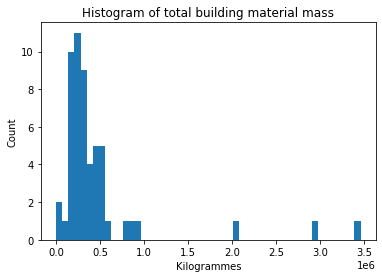

In [15]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material mass')
plt.xlabel('Kilogrammes')
plt.ylabel('Count');

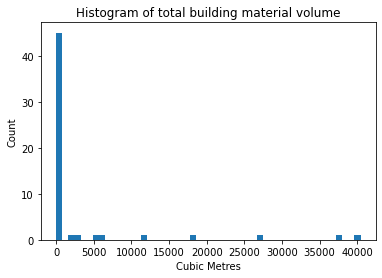

In [16]:
plt.hist(df[[c for c in df.columns if 'm3' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material volume')
plt.xlabel('Cubic Metres')
plt.ylabel('Count');

# 2. Investigate a specific material

In this example, we use the helper function `get_material_name()` to select columns which match `steel`. Then, we calculate the average amount of steel used by floor, produce a table of values by Level 3 MasterFormat only, and calculate the average values for these by year in the dataset.

In [31]:
material = 'steel'
cols = []
for column in df.columns[7:]: #Iterate through columns that represent materials
    if get_material_name(column) == 'steel' and 'kg' in column: #If that column represents steel and is a mass value:
        cols.append(column) #Append to cols

In [41]:
steel_df = df[df.columns[1:7].to_list() + cols].fillna(0) #Select only the heading columns and the columns related to steel

In [74]:
grouping_function = lambda x: x.split('_')[0] #This function takes in a full column name, like "000_G2010.20.000_03 00 00.00_m3_1", and returns only the floor.
steel_df[cols].groupby(grouping_function,axis=1).sum().mean() 

000    4631.751063
001    3067.385626
002    2827.391277
003    1748.778503
004     484.167710
005     818.053124
006     822.260903
007    1488.697400
008    1015.103971
009     653.231968
00F    7948.405146
00R     129.413985
010     488.252782
011     515.548827
012      36.441030
013      50.939630
014      35.358148
015      30.791481
016      45.260000
017      39.808611
018      25.340093
019      39.808611
020      39.808611
021     216.558611
022      20.773426
023      20.773426
024      20.787963
025      20.817037
026      72.347685
027    1026.355741
028      27.751204
029      20.555370
030      20.555370
031      22.517870
032      25.774167
033     138.751963
0P1     188.160139
0P2      82.890185
0P3     379.685602
0P4    1439.617315
999    4045.162555
B01     515.030276
M00     121.837870
M01     119.556954
P01    2825.480285
P02      17.547222
P03    1476.614537
dtype: float64

Now, we will aggregate to Level 3 MasterFormat codes, and display these values for the first three entries.

In [70]:
f = lambda x: re.split('[_\.\ ]',x)[1] #This function takes in a full column name and returns only the Level 3 MasterFormat code.
steel_general_df = pd.concat([steel_df[headings[1:]],steel_df[cols].groupby(f,axis=1).sum()],axis=1)

In [117]:
steel_general_df.head(3)

,Country,City,Quality / Stage of Data,Construction Date,Building Type,Contributor,A1010,A1020,A4010,A4020,...,B2010,B2050,B2070,B3010,B3060,C1030,C1090,D1010,G2010,G2060
0,CA,TOR,00IFC,2021,SND,Saxe Research Group University of Toronto,91.4005,0.0,285.8086,16.7488,...,0.0,0.0,0.0,81.7519,0.0,0.0,0.0,0.0,0.0,0.0
1,CA,TOR,00IFC,2021,SND,Saxe Research Group University of Toronto,0.0000,0.0,0.0000,27.1446,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,CA,TOR,00IFC,2021,SND,Saxe Research Group University of Toronto,261.3180,0.0,0.0000,15.0979,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


We can also calculate the average for each Level 3 MasterFormat code by year of construction:

In [73]:
steel_general_df.groupby('Construction Date').mean()

,A1010,A1020,A4010,A4020,A4040,A5010,A6010,B1010,B1020,B1080,B2010,B2050,B2070,B3010,B3060,C1030,C1090,D1010,G2010,G2060
Construction Date,,,,,,,,,,,,,,,,,,,,
1913,0.000000,0.000000,48.162700,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.00
1917,0.000000,0.000000,0.000000,20.81880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.00
1969,0.000000,0.000000,0.000000,98.43640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.00
1988,67016.749257,0.000000,24922.610789,0.00000,0.000000,617.952711,0.000000,129.786585,0.000000,5677.162679,5039.204304,0.000000,0.000,0.000000,0.000,0.000000,0.000000,334.146341,0.000,0.00
2007,0.000000,122069.070000,68246.330000,0.00000,0.000000,0.000000,0.000000,32828.900000,2249.000000,86571.370000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,16665.000000,7925.800000,0.000,0.00
2009,92590.750000,0.000000,58354.545000,0.00000,0.000000,0.000000,0.000000,77762.100000,63740.722253,0.000000,1062.890000,0.000000,88591.000,0.000000,0.000,0.000000,0.000000,6959.600000,3242.050,0.00
2011,10048.588750,11019.437500,17521.985000,0.00000,180.157500,815.260000,0.000000,92701.751675,0.000000,2180.730000,1425.050000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,988.315,1698.74
2016,0.000000,113531.410000,14850.630000,0.00000,470.215000,0.000000,0.000000,16048.100000,0.000000,6437.785000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.00
2017,8946.288121,3728.788900,7498.122611,0.00000,927.640379,0.000000,0.000000,426847.063700,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.00


# 3. Uncertainty by Building Type

In this section, we look at the uncertainty code associated with each column. We collect these by building type and then report the number of each value per type of building.

In [97]:
uncertainty_level = {} 
for k,v in df.iterrows():
    #Initialise empty lists for each building type as they occur
    if v['Building Type'] not in uncertainty_level.keys():
        uncertainty_level[v['Building Type']] = []
    #Append the uncertainty value for each column that is non-NaN
    for key in v[~v.isna()].keys()[7:]:
        uncertainty_level[v['Building Type']].append(key.split('_')[-1])

In [98]:
from collections import Counter

In [100]:
for k,v in uncertainty_level.items():
    uncertainty_level[k] = Counter(v) #Construct a Counter object per building type

In [101]:
uncertainty_level

{'SND': Counter({'1': 1720, '2': 711, '4': 349}),
 'OFF': Counter({'1': 494, '3': 307}),
 'APB': Counter({'1': 358, '2': 1, '3': 314}),
 'SMD': Counter({'1': 191, '2': 61, '4': 27}),
 'EDU': Counter({'1': 93, '3': 24, '2': 6}),
 'INS': Counter({'1': 90, '3': 77, '2': 1}),
 'ROW': Counter({'1': 15, '3': 5}),
 'MIX': Counter({'1': 315})}

Next, we aggregate columns by use code and uncertainty combined, and report the average by building type.

In [107]:
f = lambda x: re.split('[_\.\ ]',x)[1][0] + x.split('_')[-1] #From a full code, return only the use code and uncertainty code.
by_function_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)

In [113]:
by_function_df.groupby('Building Type').mean()

,Construction Date,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,D1,G3
Building Type,,,,,,,,,,,,,
APB,2014.50,101344.154000,0.000000,74241.767500,0.000000,6090.412000,0.0000,38926.972500,0.000000,480.271137,0.000,0.000000,0.000000
EDU,2016.50,0.000000,0.000000,74976.547506,0.000000,221447.581850,0.0000,3218.892500,0.000000,0.000000,0.000,0.000000,0.000000
INS,1988.00,0.000000,0.000000,92557.312757,0.000000,129.786585,0.0000,10716.366983,0.000000,0.000000,0.000,334.146341,0.000000
MIX,2018.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
OFF,2009.00,0.000000,0.000000,127794.205833,0.000000,149228.155201,0.0000,29491.141667,0.000000,5555.000000,0.000,4961.800000,2872.053333
ROW,2018.00,0.000000,0.000000,0.000000,0.000000,7019.600000,0.0000,1088.010000,0.000000,0.000000,0.000,0.000000,0.000000
SMD,1994.75,82.653250,11.036450,0.000000,4.246275,0.000000,0.0000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
SND,2015.60,676.023563,68.474865,0.000000,20.342905,115.462900,55.4561,0.000000,6.686572,0.000000,17.289,0.000000,0.000000


Lastly, we report the total amount of material falling under each uncertainty code by year of construction.

In [118]:
f = lambda x: x.split('_')[-1] #Select only the uncertainty code.
pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Construction Date').mean()

,1,2,3,4
Construction Date,,,,
1913,48.162700,0.000000,0.000000,0.000000
1917,0.000000,20.818800,0.000000,0.000000
1969,0.000000,98.436400,0.000000,0.000000
1988,463.932927,0.000000,103273.679739,0.000000
2007,59668.700000,0.000000,276886.770000,0.000000
2009,237053.422253,0.000000,155250.235000,0.000000
2011,93514.931675,0.000000,45065.083750,0.000000
2016,16048.100000,0.000000,135290.040000,0.000000
2017,426847.063700,0.000000,21100.840011,0.000000
